# CINEMA TICKET SALES FORECASTING
###### ALENA MARIA THOMAS (MDS202303) alena.mds2023@cmi.ac.in
###### DIVYANSHI KUMARI (MDS202322) divyanshi.mds2023@cmi.ac.in

**Overview**

One of the Major data-driven solutions that ML and Data Science has empowered organizations and businesses is to be able to Forecast and Predict Total Sales.

Some major benefits of forecasting future sales are:

- Sales drives everything else; it is what determines the expense spending plan,i.e the production plan of the organisation.
- Allows film-makers to efficiently allocate resources for future growth and manage their finances.
- Enables continuous strategic planning - By understanding the future rate of sale, the film-makers can improve pricing , product development and advertise accordingly.

In this notebook, we will be utilizing time series analysis to forecast total ticket sales.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arashnic/cinema-ticket")

print("Path to dataset files:", path)


100%|██████████| 3.27M/3.27M [00:00<00:00, 50.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/arashnic/cinema-ticket/versions/2


## 1. Loading and Cleaning Dataset

### 1.1. Importing necessary libraries

In [ ]:
# @title
#preprocessing and visualization modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.style
matplotlib.style.use('bmh')
import seaborn as sns

#Time series and ML modules
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
!pip install pmdarima
from pmdarima import auto_arima
import pmdarima as pmd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.8 MB/s eta 0:00:00


### 1.2 Loading dataset

In [ ]:
import os

# List all files in the downloaded dataset directory
for file_name in os.listdir(path):
    file=file_name
    print(file_name)

# Access a specific file
file_path = os.path.join(path, file)  # Replace 'filename.csv' with the actual file name
with open(file_path, 'r') as file:
    # Do something with the file, e.g., read it with pandas
    import pandas as pd
    df = pd.read_csv(file)


cinemaTicket_Ref.csv


In [ ]:
df.head()

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
0,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5
1,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5
2,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,2018-05-05,5,2,5
3,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,2018-05-05,5,2,5
4,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,2018-05-05,5,2,5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142524 entries, 0 to 142523
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   film_code     142524 non-null  int64  
 1   cinema_code   142524 non-null  int64  
 2   total_sales   142524 non-null  int64  
 3   tickets_sold  142524 non-null  int64  
 4   tickets_out   142524 non-null  int64  
 5   show_time     142524 non-null  int64  
 6   occu_perc     142399 non-null  float64
 7   ticket_price  142524 non-null  float64
 8   ticket_use    142524 non-null  int64  
 9   capacity      142399 non-null  float64
 10  date          142524 non-null  object 
 11  month         142524 non-null  int64  
 12  quarter       142524 non-null  int64  
 13  day           142524 non-null  int64  
dtypes: float64(3), int64(10), object(1)
memory usage: 15.2+ MB


In [ ]:
df.shape

(142524, 14)

In [ ]:
# reordering dataset based on date

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values(by='date')
df = df.reset_index(drop=True)
df.head()

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
0,1471,448,32030000,267,0,2,47.76,119962.546816,267,559.045226,2018-02-21,2,1,21
1,1471,518,180000,3,0,1,2.07,60000.000000,3,144.927536,2018-02-23,2,1,23
2,1485,304,43200000,363,0,8,21.42,119008.264463,363,1694.677871,2018-03-14,3,1,14
3,1483,83,300000,3,0,10,0.21,100000.000000,3,1428.571429,2018-03-14,3,1,14
4,1483,262,560000,7,0,3,0.73,80000.000000,7,958.904110,2018-03-14,3,1,14


### 1.3. Checking for null values

In [ ]:
df.isnull().sum()

,0
film_code,0
cinema_code,0
total_sales,0
tickets_sold,0
tickets_out,0
show_time,0
occu_perc,125
ticket_price,0
ticket_use,0
capacity,125


In [ ]:
(df.isna().mean() * 100).to_frame(name="Null (%)")

,Null (%)
film_code,0.000000
cinema_code,0.000000
total_sales,0.000000
tickets_sold,0.000000
tickets_out,0.000000
show_time,0.000000
occu_perc,0.087705
ticket_price,0.000000
ticket_use,0.000000
capacity,0.087705


A very small percentage of rows have NA values. So, we can drop them with no harm.

In [ ]:
df.dropna(inplace=True)
df.isnull().sum()

,0
film_code,0
cinema_code,0
total_sales,0
tickets_sold,0
tickets_out,0
show_time,0
occu_perc,0
ticket_price,0
ticket_use,0
capacity,0


### 1.4 Checking for duplicate values

In [ ]:
def check_duplicates(df, column, show_duplicates=False):
    duplicates = df[df.duplicated(subset=column)]

    if duplicates.empty:
        print(f'STATUS: There are no duplicate values in the column "{column}".')
    else:
        duplicate_count = len(duplicates)
        print(f'STATUS: There are {duplicate_count} duplicate values in the column "{column}".')

check_duplicates(df, "date", show_duplicates=True)

STATUS: There are 142165 duplicate values in the column "date".


In [ ]:
check_duplicates(df, "film_code", show_duplicates=True)


STATUS: There are 142351 duplicate values in the column "film_code".


In [ ]:
check_duplicates(df, "cinema_code", show_duplicates=True)

STATUS: There are 142155 duplicate values in the column "cinema_code".


In [ ]:
unique_films = df['film_code'].nunique()
unique_cinemas = df['cinema_code'].nunique()
unique_showtime = df['show_time'].nunique()
print(f"{unique_films} unique films.")
print(f"{unique_cinemas} unique cinemas. ")
print(f"{unique_showtime} unique showtime. ")

48 unique films.
244 unique cinemas. 
51 unique showtime. 


A certain movie has been repeated at multiple cinemas on multiple days.

In [ ]:
cols = ['film_code','cinema_code','date']
df['id']=df[cols].apply(lambda row:'_'.join(row.values.astype(str)), axis=1)

In [ ]:
df.head()

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day,id
0,1471,448,32030000,267,0,2,47.76,119962.546816,267,559.045226,2018-02-21,2,1,21,1471_448_2018-02-21 00:00:00
1,1471,518,180000,3,0,1,2.07,60000.000000,3,144.927536,2018-02-23,2,1,23,1471_518_2018-02-23 00:00:00
2,1485,304,43200000,363,0,8,21.42,119008.264463,363,1694.677871,2018-03-14,3,1,14,1485_304_2018-03-14 00:00:00
3,1483,83,300000,3,0,10,0.21,100000.000000,3,1428.571429,2018-03-14,3,1,14,1483_83_2018-03-14 00:00:00
4,1483,262,560000,7,0,3,0.73,80000.000000,7,958.904110,2018-03-14,3,1,14,1483_262_2018-03-14 00:00:00


In [ ]:
check_duplicates(df, "id", show_duplicates=True)

STATUS: There are 104 duplicate values in the column "id".


In [ ]:
df.drop_duplicates(keep='first')

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day,id
0,1471,448,32030000,267,0,2,47.76,119962.546816,267,559.045226,2018-02-21,2,1,21,1471_448_2018-02-21 00:00:00
1,1471,518,180000,3,0,1,2.07,60000.000000,3,144.927536,2018-02-23,2,1,23,1471_518_2018-02-23 00:00:00
2,1485,304,43200000,363,0,8,21.42,119008.264463,363,1694.677871,2018-03-14,3,1,14,1485_304_2018-03-14 00:00:00
3,1483,83,300000,3,0,10,0.21,100000.000000,3,1428.571429,2018-03-14,3,1,14,1483_83_2018-03-14 00:00:00
4,1483,262,560000,7,0,3,0.73,80000.000000,7,958.904110,2018-03-14,3,1,14,1483_262_2018-03-14 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142519,1587,164,770000,11,0,4,6.25,70000.000000,11,176.000000,2018-11-04,11,4,4,1587_164_2018-11-04 00:00:00
142520,1587,181,1040000,13,0,4,2.17,80000.000000,13,599.078341,2018-11-04,11,4,4,1587_181_2018-11-04 00:00:00
142521,1587,160,1520000,19,0,3,0.94,80000.000000,19,2021.276596,2018-11-04,11,4,4,1587_160_2018-11-04 00:00:00
142522,1587,474,3880000,43,0,2,68.25,90232.558140,43,63.003663,2018-11-04,11,4,4,1587_474_2018-11-04 00:00:00


## 2. EDA and Visualization

##### Film_Code based Visualisation

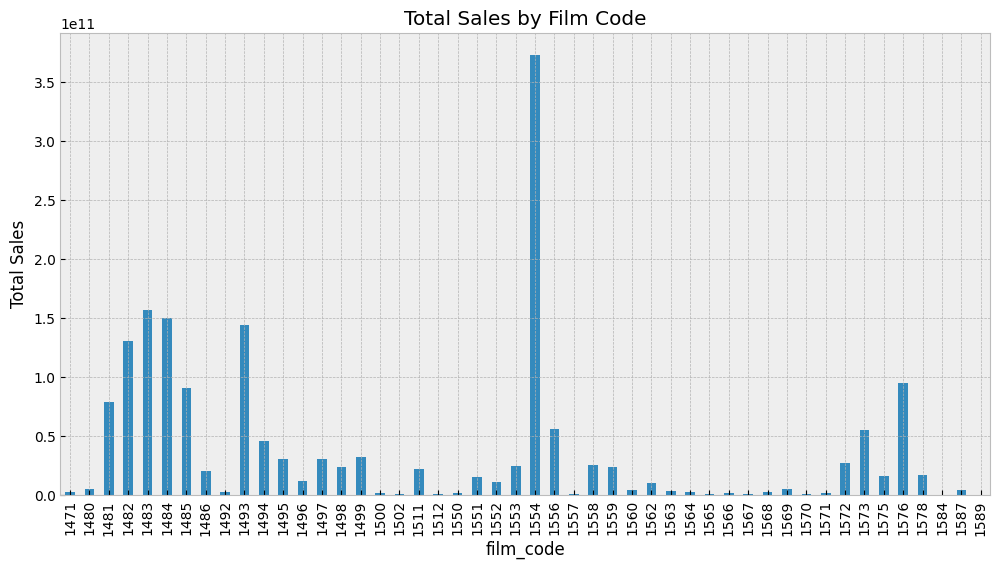

In [ ]:
# Grouping by film_code and calculating total sales
film_sales = df.groupby('film_code')['total_sales'].sum()

# Plotting the total sales for each film code
film_sales.plot(kind='bar', figsize=(12, 6), title='Total Sales by Film Code')
plt.ylabel('Total Sales')
plt.show()


In [ ]:
import pandas as pd


df['date'] = pd.to_datetime(df['date'])


df['year_month'] = df['date'].dt.to_period('M')
monthly_sales = df.groupby(['year_month', 'film_code'])['total_sales'].max().reset_index()

highest_sales_per_month = monthly_sales.loc[monthly_sales.groupby('year_month')['total_sales'].idxmax()]

# Calculate total sales for each month
total_sales_per_month = df.groupby('year_month')['total_sales'].sum().reset_index()
total_sales_per_month.rename(columns={'total_sales': 'monthly_total_sales'}, inplace=True)


highest_sales_per_month = highest_sales_per_month.merge(total_sales_per_month, on='year_month')

# Calculate the percentage contribution
highest_sales_per_month['percentage_contribution'] = (highest_sales_per_month['total_sales'] / highest_sales_per_month['monthly_total_sales']) * 100

# Convert 'year_month' period to string for better readability
highest_sales_per_month['year_month'] = highest_sales_per_month['year_month'].astype(str)

# Display the table
print(highest_sales_per_month[['year_month', 'film_code', 'total_sales', 'percentage_contribution']])


  year_month  film_code  total_sales  percentage_contribution
0    2018-02       1471     32030000                99.441167
1    2018-03       1483    680021000                 0.353946
2    2018-04       1483    856010000                 0.245619
3    2018-05       1495    470969995                 0.196577
4    2018-06       1493    310559997                 0.298611
5    2018-07       1554   1262819994                 0.476796
6    2018-08       1554   1058979995                 0.410020
7    2018-09       1576    623540000                 0.645711
8    2018-10       1573    695189993                 0.300090
9    2018-11       1576    371610000                 1.637623


For most other months, the top-performing film contributes very little (well below 1%) to the overall sales, showing that the total sales are distributed among multiple films.
Film code has a relatively small influence on monthly sales across most months. Even though specific films can perform well, they do not dominate the overall sales in most months, except in February.
Overall, film_code seems to be a less significant factor in affecting total sales on monthly basis, except for specific outlier months like February.

In [ ]:
import pandas as pd
df['date'] = pd.to_datetime(df['date'])

df['year_week'] = df['date'].dt.to_period('W')

weekly_sales = df.groupby(['year_week', 'film_code'])['total_sales'].max().reset_index()


highest_sales_per_week = weekly_sales.loc[weekly_sales.groupby('year_week')['total_sales'].idxmax()]

# Calculate total sales for each week
total_sales_per_week = df.groupby('year_week')['total_sales'].sum().reset_index()
total_sales_per_week.rename(columns={'total_sales': 'weekly_total_sales'}, inplace=True)


highest_sales_per_week = highest_sales_per_week.merge(total_sales_per_week, on='year_week')

# Calculate the percentage contribution
highest_sales_per_week['percentage_contribution'] = (highest_sales_per_week['total_sales'] / highest_sales_per_week['weekly_total_sales']) * 100


highest_sales_per_week['year_week'] = highest_sales_per_week['year_week'].astype(str)

# Display the table
print(highest_sales_per_week[['year_week', 'film_code', 'total_sales', 'percentage_contribution']])


                year_week  film_code  total_sales  percentage_contribution
0   2018-02-19/2018-02-25       1471     32030000                99.441167
1   2018-03-12/2018-03-18       1483    431403994                 2.302811
2   2018-03-19/2018-03-25       1483    654849994                 1.045438
3   2018-03-26/2018-04-01       1483    856010000                 0.649499
4   2018-04-02/2018-04-08       1483    586355494                 0.706143
5   2018-04-09/2018-04-15       1483    514234997                 0.568231
6   2018-04-16/2018-04-22       1493    518059991                 0.687887
7   2018-04-23/2018-04-29       1493    542499983                 0.735665
8   2018-04-30/2018-05-06       1495    470969995                 0.652460
9   2018-05-07/2018-05-13       1493    415654994                 0.692640
10  2018-05-14/2018-05-20       1493    274290000                 0.562637
11  2018-05-21/2018-05-27       1493    436334990                 1.034682
12  2018-05-28/2018-06-03

The film_code does influence the weekly sales, but its effect is inconsistent across weeks. While some weeks see a dominant film (e.g., 99.44% in one week), for most weeks, the contribution of the top-selling film is much smaller, typically ranging from 0.5% to 3%. This indicates that while a single film can significantly impact a week's sales, multiple films can also share the sales in most weeks, making film_code a contributing but not always dominant factor in weekly sales.

##### Daily Sales EDA

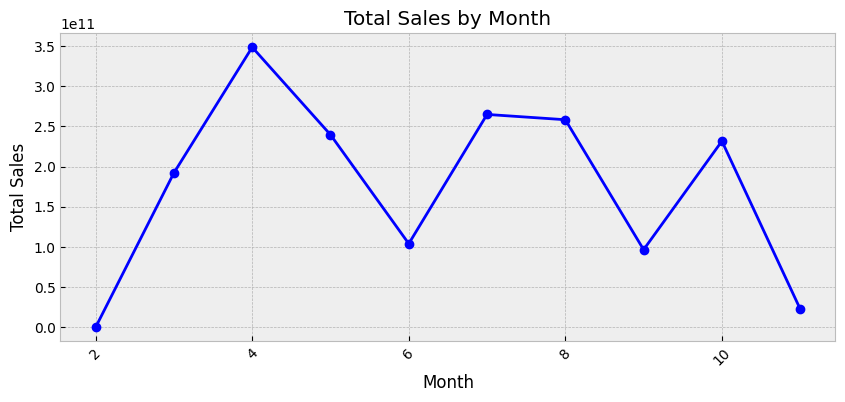

In [ ]:
monthly_sales = df.groupby('month')['total_sales'].sum()

# Plotting total sales by month
plt.figure(figsize=(10, 4))
monthly_sales.plot(kind='line', marker='o',color='blue')
plt.title("Total Sales by Month")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.show()


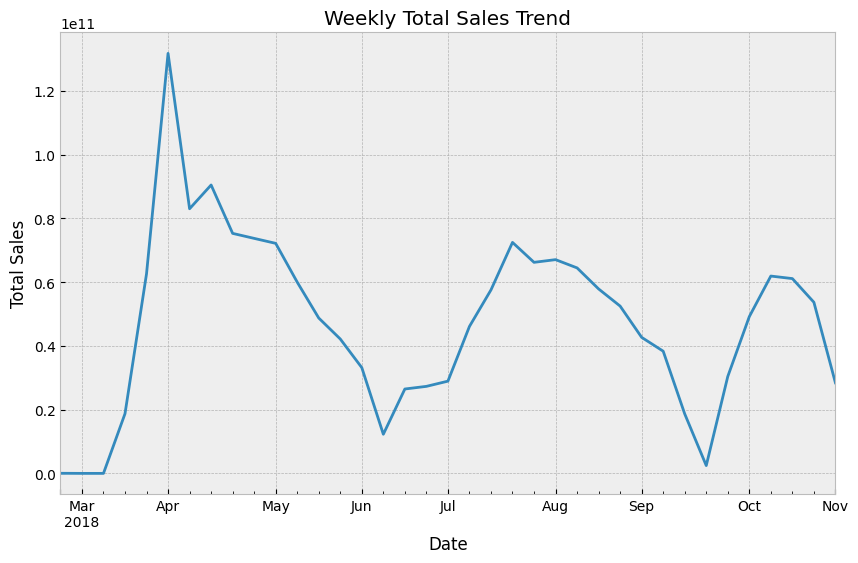

In [ ]:
# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Set the date as the index, resample by week, and plot total sales
df.set_index('date').resample('W')['total_sales'].sum().plot(figsize=(10, 6))
plt.title("Weekly Total Sales Trend")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.show()


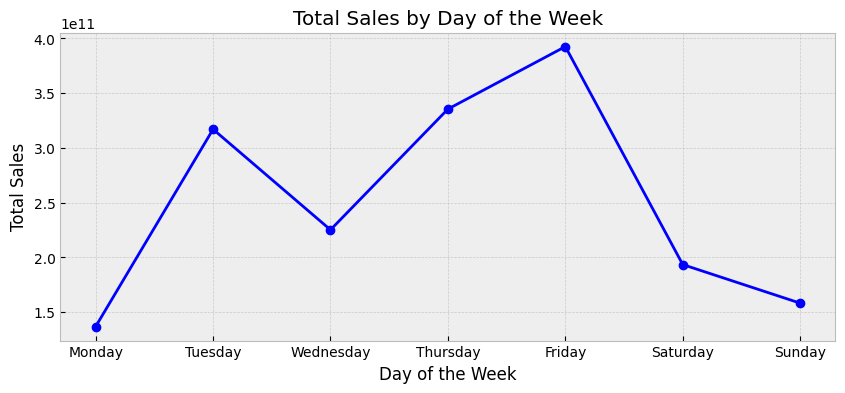

In [ ]:
# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract day of the week from the date column
df['day_of_week'] = df['date'].dt.day_name()

# Group by day of the week and calculate total sales for each day
weekly_sales = df.groupby('day_of_week')['total_sales'].sum().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

# Plotting total sales by day of the week
plt.figure(figsize=(10, 4))
weekly_sales.plot(kind='line', marker='o', color='blue', linestyle='-', linewidth=2, markersize=6)
plt.title("Total Sales by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Total Sales")
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.show()


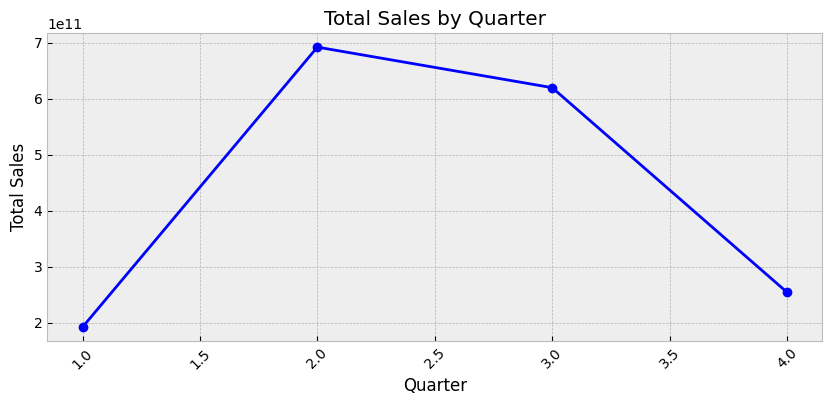

In [ ]:
# Group by the 'quarter' column and sum up total sales for each quarter
quarterly_sales = df.groupby('quarter')['total_sales'].sum()

# Plotting total sales by quarter
plt.figure(figsize=(10, 4))
quarterly_sales.plot(kind='line', marker='o',color='blue')
plt.title("Total Sales by Quarter")
plt.xlabel("Quarter")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Group by 'date' and calculate total sales for each day
daily_sales = df.groupby('date')['total_sales'].sum()
daily_sales = daily_sales.reset_index(level=0) # to convert series to a dataframe
daily_sales.head()

,date,total_sales
0,2018-02-21,32030000
1,2018-02-23,180000
2,2018-03-14,2202300484
3,2018-03-15,4479008974
4,2018-03-16,5386645987


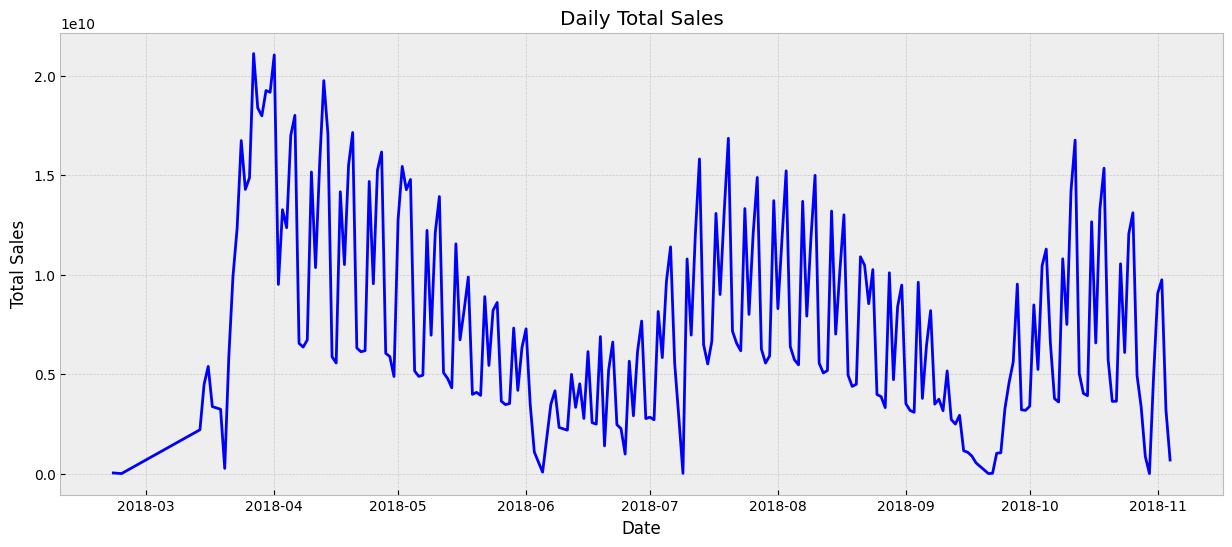

In [ ]:
# Plotting daily total sales
plt.figure(figsize=(15, 6))
plt.plot(daily_sales['date'], daily_sales['total_sales'], color='blue', linewidth=2)
plt.title("Daily Total Sales")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
daily_sales.shape

(234, 2)

**Some Critical Insights :**

- Total sales are higher than the above average in the 2nd and 3rd quarter.
- Sales seem to be critically down during the start and the end of the year.
- According to this data, September seems to be unpopular for watching movies in the theatre.
- The pre weekend days do better than the weekends

#####Occupancy Percentage

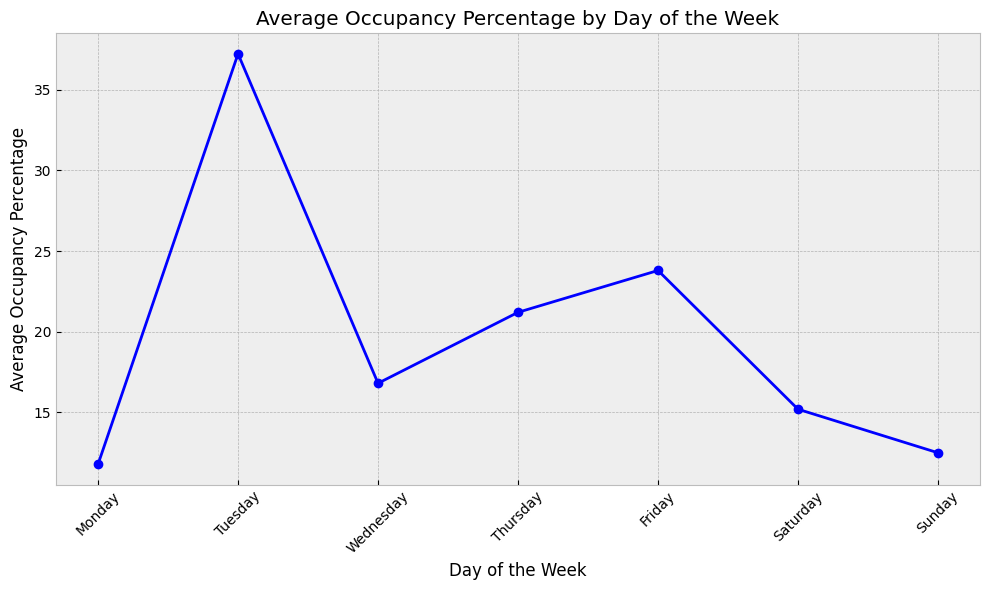

In [ ]:
df['date'] = pd.to_datetime(df['date'])

# Extract day of the week (0=Monday, 6=Sunday)
df['day_of_week'] = df['date'].dt.dayofweek

# Group by day of the week and calculate the mean occupancy percentage
daywise_occupancy = df.groupby('day_of_week')['occu_perc'].mean()

# Map numeric day values to actual weekday names
daywise_occupancy.index = daywise_occupancy.index.map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
    4: 'Friday', 5: 'Saturday', 6: 'Sunday'
})

# Plotting the line graph
plt.figure(figsize=(10, 6))
plt.plot(daywise_occupancy.index, daywise_occupancy.values, marker='o', linestyle='-', color='b')
plt.title('Average Occupancy Percentage by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Occupancy Percentage')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
correlation = df[['occu_perc', 'total_sales']].corr()
print(correlation)


             occu_perc  total_sales
occu_perc     1.000000     0.414418
total_sales   0.414418     1.000000


# SEASONAL DECOMPOSITION

<Figure size 1800x1400 with 0 Axes>

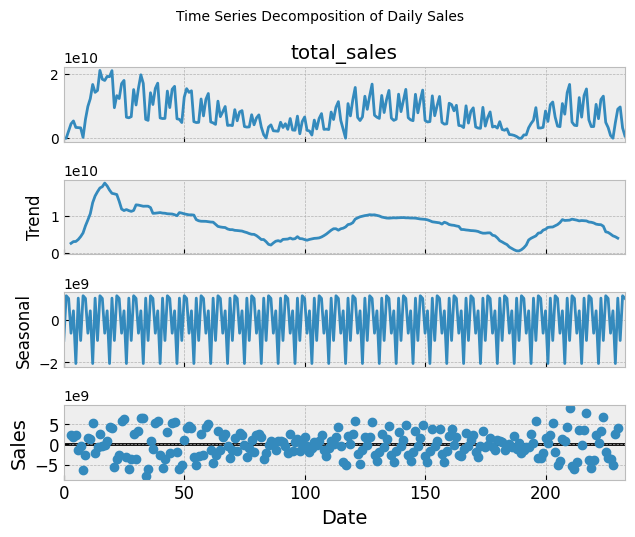

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming daily_sales is your DataFrame with a 'total_sales' column

# Decompose the time series with an additive model
decomposition = seasonal_decompose(daily_sales['total_sales'], model='additive', period=7)  # Weekly seasonality

# Create a larger figure with increased size
plt.figure(figsize=(18, 14))  # Increased figure size

# Plot the decomposed components
decomposition.plot()

# Adjust the title and labels for better readability
plt.suptitle('Time Series Decomposition of Daily Sales', fontsize=10, y=1.05)
plt.subplots_adjust(top=0.93)  # Adjust the space for the suptitle

# Customize axes and labels for better clarity
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales', fontsize=14)

# Increase font size for ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()


## 3. Checking Stationarity




### 3.1. ADF Test

The ADF test is a statistical tool to check whether our dataset is stationary or not.

The ADF test is an extension of the Dickey-Fuller test that includes lagged differences of the time series to account for higher-order autocorrelation.

The ADF test tests the null hypothesis that a unit root is present in the time series (i.e., the time series is non-stationary) against the alternative hypothesis that the series is stationary.

Hypotheses:

**Null Hypothesis ($H_0$):** The time series has a unit root (i.e., it is non-stationary).

**Alternative Hypothesis ($H_1$):** The time series does not have a unit root (i.e., it is stationary).

In [ ]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'Critical value: {result[0]:.2f}')
    print(f'p-value: {result[1]:.2f}')
    print(f'Lags used: {result[2]}')
    print('Threshold values:')
    for key, value in result[4].items():
      print(f"\t{key}: {value:.2f}")

# Test on total_sales
adf_test(daily_sales['total_sales'])

Critical value: -2.48
p-value: 0.12
Lags used: 14
Threshold values:
	1%: -3.46
	5%: -2.87
	10%: -2.57


Since p-value is greater than $0.05$, we cannot reject the null hypothesis ($H_0$).

Hence the dataset is not stationary.

### 3.2 Normalizing the dataset

In [ ]:
import numpy as np

# Apply log transformation to 'total_sales' in daily_sales
daily_sales['total_sales_log'] = np.log(daily_sales['total_sales'])

daily_sales.head(2)


,date,total_sales,total_sales_log
0,2018-02-21,32030000,17.282184
1,2018-02-23,180000,12.100712


In [ ]:
# First difference of log-transformed data
daily_sales['total_sales_log_diff'] = daily_sales['total_sales_log'].diff().dropna()
daily_sales.head(3)

,date,total_sales,total_sales_log,total_sales_log_diff
0,2018-02-21,32030000,17.282184,NaN
1,2018-02-23,180000,12.100712,-5.181471
2,2018-03-14,2202300484,21.512768,9.412056


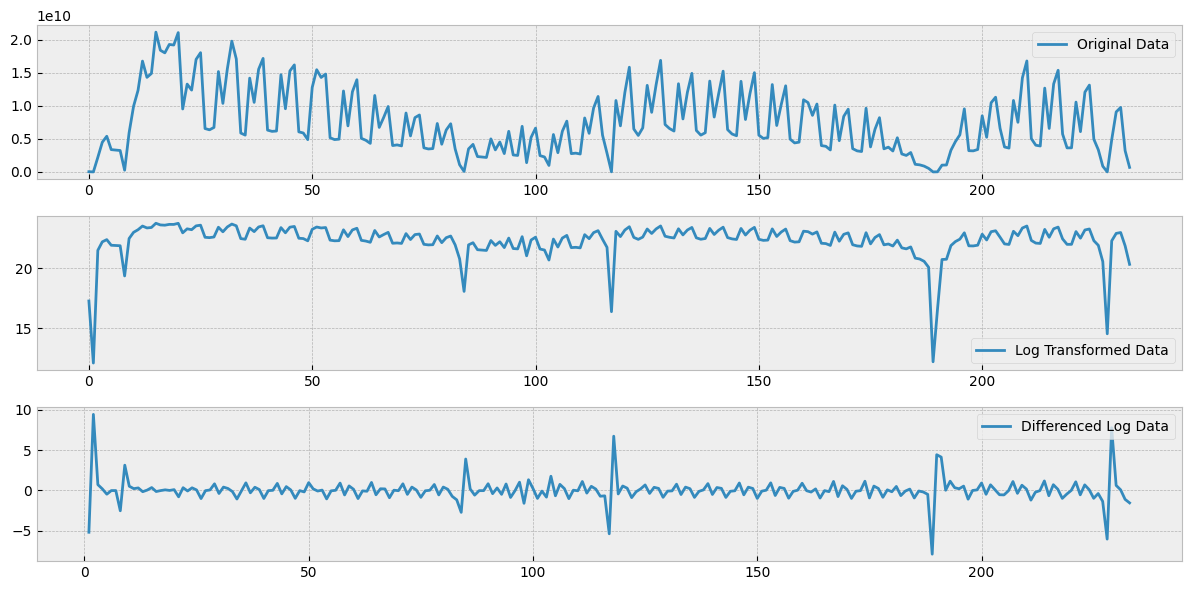

In [ ]:
# Plot original, log-transformed, and differenced data
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(daily_sales['total_sales'], label='Original Data')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(daily_sales['total_sales_log'], label='Log Transformed Data')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(daily_sales['total_sales_log_diff'], label='Differenced Log Data')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
adf_test(daily_sales['total_sales_log_diff'].dropna())

Critical value: -11.59
p-value: 0.00
Lags used: 5
Threshold values:
	1%: -3.46
	5%: -2.87
	10%: -2.57


Since the p-value is less than $0.05$, hence we can reject the null hypothesis ($H_0$).

Hence, the data is now stationary.

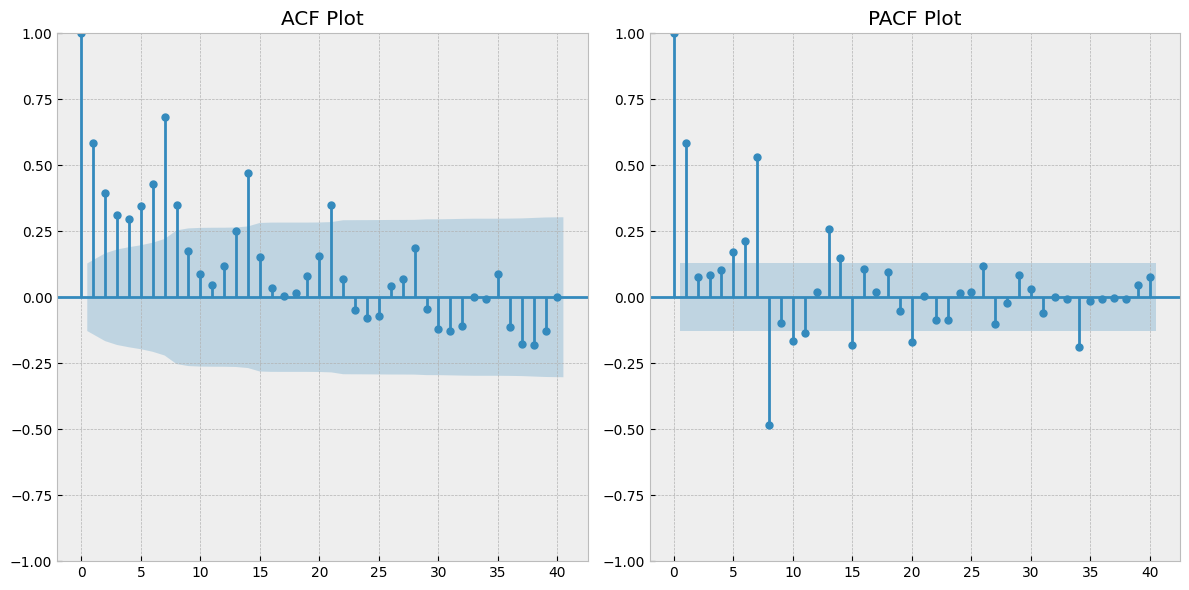

In [ ]:
plt.figure(figsize=(12, 6))

# ACF plot
plt.subplot(121)
plot_acf(daily_sales['total_sales'].dropna(), lags=40, ax=plt.gca())
plt.title('ACF Plot')

# PACF plot
plt.subplot(122)
plot_pacf(daily_sales['total_sales'].dropna(), lags=40, ax=plt.gca())
plt.title('PACF Plot')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Assuming daily_sales is your DataFrame with a DateTime index and 'total_sales' column

# Sort the data by date (in case it's not already sorted)
daily_sales = daily_sales.sort_index()

# Define the length of the test set (14 days)
test_size = 14

# Split the data: last 14 days as test set, the rest as training set
train = daily_sales.iloc[:-test_size]
test = daily_sales.iloc[-test_size:]


## 4. Forecasting with Moving Average

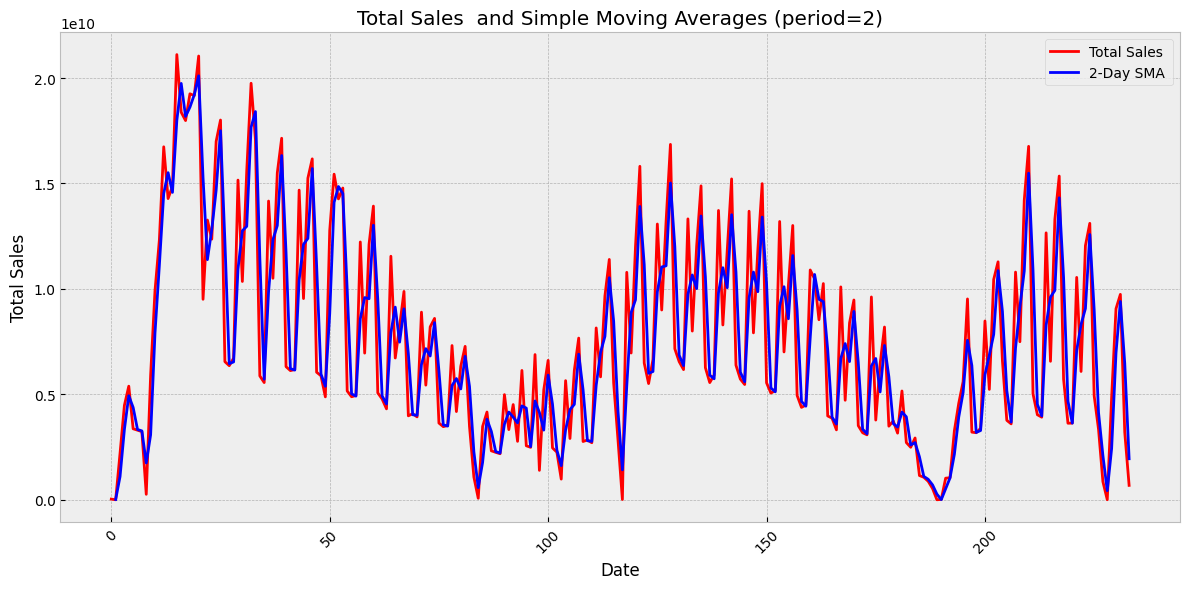

In [ ]:
import matplotlib.pyplot as plt

# Calculate SMA for different windows
daily_sales['SMA_2'] = daily_sales['total_sales'].rolling(window=2).mean()
daily_sales['SMA_7'] = daily_sales['total_sales'].rolling(window=7).mean()
daily_sales['SMA_14'] = daily_sales['total_sales'].rolling(window=14).mean()

# Plot the total_sales_log and SMAs
plt.figure(figsize=(12, 6))

# Plot the total_sales_log
plt.plot(daily_sales.index, daily_sales['total_sales'], label='Total Sales ', color='red')

# Plot the 2-day, 7-day, and 14-day SMAs
plt.plot(daily_sales.index, daily_sales['SMA_2'], label='2-Day SMA', color='blue')

plt.title('Total Sales  and Simple Moving Averages (period=2)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


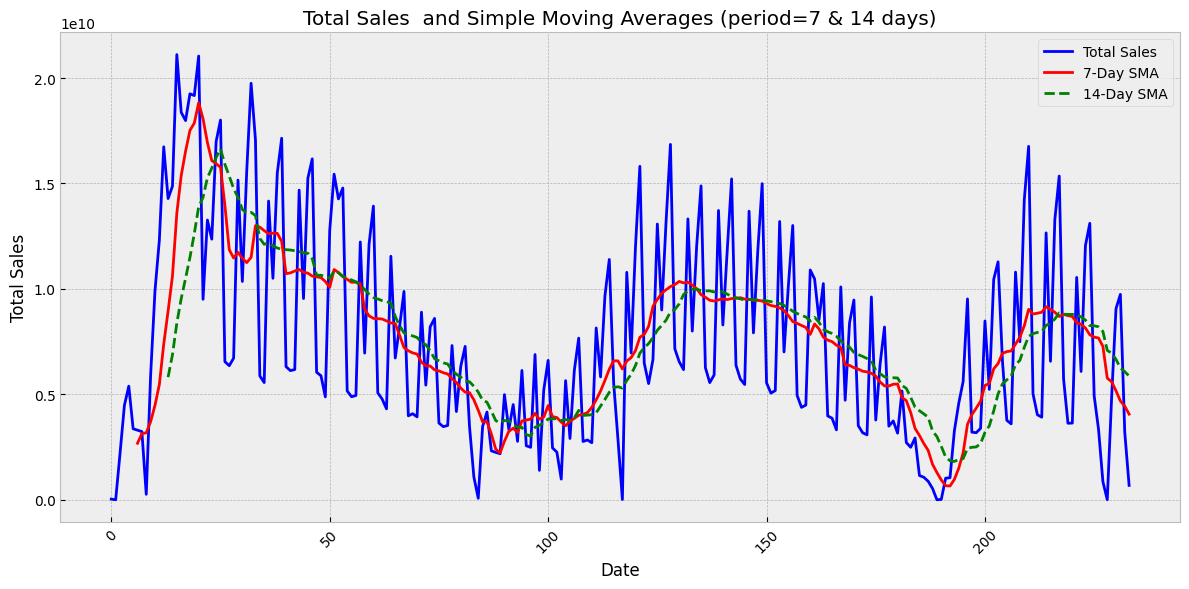

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales['total_sales'], label='Total Sales ', color='blue')
plt.plot(daily_sales.index, daily_sales['SMA_7'], label='7-Day SMA', color='red')
plt.plot(daily_sales.index, daily_sales['SMA_14'], label='14-Day SMA', color='green', linestyle='--')

# Add titles and labels
plt.title('Total Sales  and Simple Moving Averages (period=7 & 14 days)')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Total Sales')

# Show the legend
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


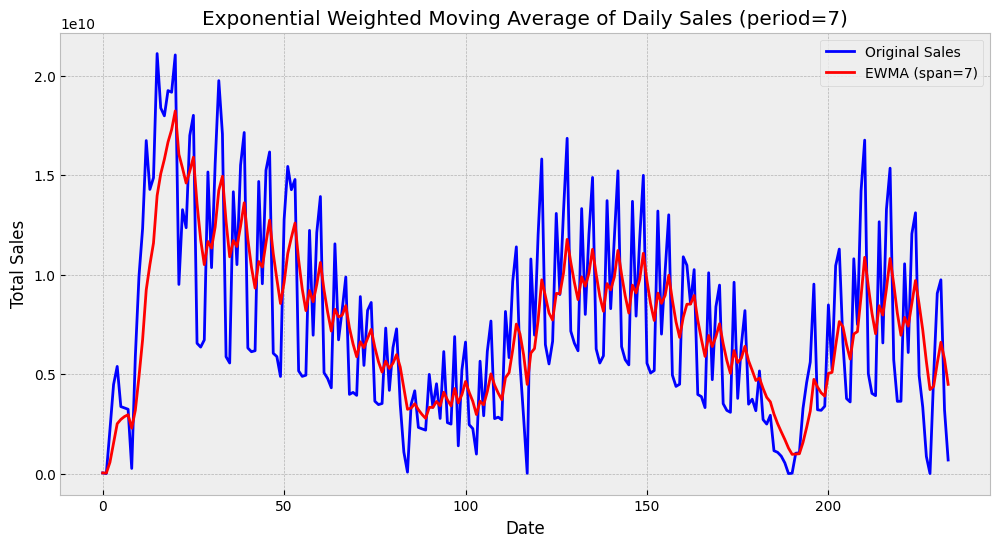

In [ ]:
daily_sales['EWMA_7'] = daily_sales['total_sales'].ewm(span=7, adjust=False).mean()

# Plot the original and EWMA smoothed series
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['total_sales'], label='Original Sales', color='blue')
plt.plot(daily_sales['EWMA_7'], label='EWMA (span=7)', color='red')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Exponential Weighted Moving Average of Daily Sales (period=7)')
plt.legend()
plt.show()

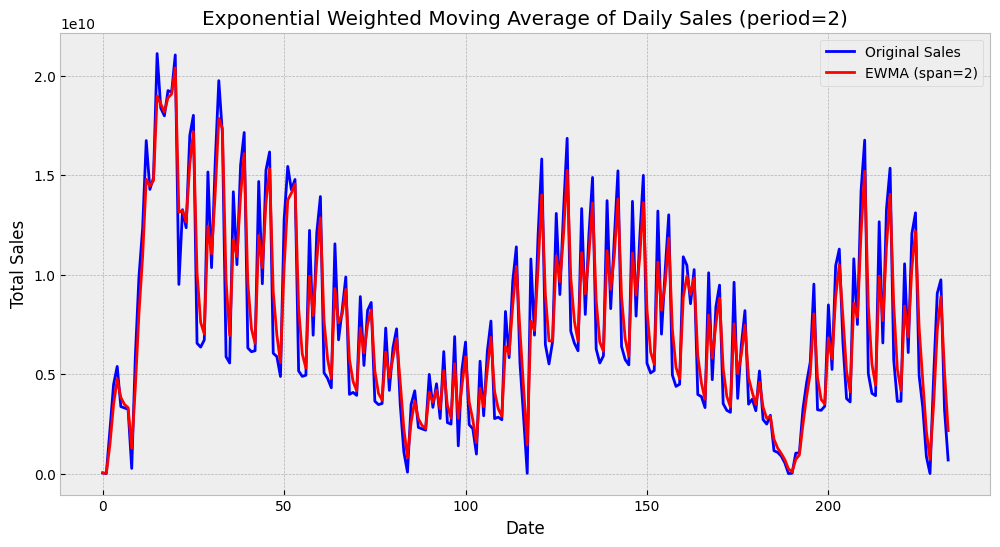

In [ ]:
daily_sales['EWMA_2'] = daily_sales['total_sales'].ewm(span=2, adjust=False).mean()

# Plot the original and EWMA smoothed series
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['total_sales'], label='Original Sales', color='blue')
plt.plot(daily_sales['EWMA_2'], label='EWMA (span=2)', color='red')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Exponential Weighted Moving Average of Daily Sales (period=2)')
plt.legend()
plt.show()

In [ ]:
daily_sales.fillna(0, inplace=True)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def calculate_metrics(y_true, y_pred):
    """
    Function to calculate RMSE, MAE, and MSE.

    Parameters:
    y_true (Series or array): The actual values.
    y_pred (Series or array): The predicted values.

    Returns:
    dict: A dictionary containing the RMSE, MAE, and MSE values.
    """

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Return the results as a dictionary
    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse
    }




In [ ]:
# Define the actual sales values for the entire dataset
y_true = daily_sales['total_sales']

# Define the predicted values (SMAs and EWMA) for the entire dataset
y_pred_2 = daily_sales['SMA_2']         # Predicted values (2-day SMA)
y_pred_7 = daily_sales['SMA_7']         # Predicted values (7-day SMA)
y_pred_14 = daily_sales['SMA_14']       # Predicted values (14-day SMA)
y_pred_ewma2 = daily_sales['EWMA_2']    # Predicted values (EWMA with span 2)
y_pred_ewma7 = daily_sales['EWMA_7']    # Predicted values (EWMA with span 7)

# Assuming `test_index` is the index corresponding to the test set in your data
test_index = test.index  # This should be the index from your test set, e.g., the last 14 days

# Filter the true and predicted values based on the test set index
y_true_test = y_true.loc[test_index]
y_pred_2_test = y_pred_2.loc[test_index]
y_pred_7_test = y_pred_7.loc[test_index]
y_pred_14_test = y_pred_14.loc[test_index]
y_pred_ewma2_test = y_pred_ewma2.loc[test_index]
y_pred_ewma7_test = y_pred_ewma7.loc[test_index]

# Calculate metrics for the 2-Day, 7-Day, and 14-Day SMAs and EWMA for the test set
metrics_2 = calculate_metrics(y_true_test, y_pred_2_test)
metrics_7 = calculate_metrics(y_true_test, y_pred_7_test)
metrics_14 = calculate_metrics(y_true_test, y_pred_14_test)
metrics_ewma2 = calculate_metrics(y_true_test, y_pred_ewma2_test)
metrics_ewma7 = calculate_metrics(y_true_test, y_pred_ewma7_test)

# Create a DataFrame to display the results in a table format
metrics_df_sma = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'RMSE'],
    '2-Day SMA': [metrics_2['MSE'], metrics_2['MAE'], metrics_2['RMSE']],
    '7-Day SMA': [metrics_7['MSE'], metrics_7['MAE'], metrics_7['RMSE']],
    '14-Day SMA': [metrics_14['MSE'], metrics_14['MAE'], metrics_14['RMSE']],
    'EWMA (span=2)': [metrics_ewma2['MSE'], metrics_ewma2['MAE'], metrics_ewma2['RMSE']],
    'EWMA (span=7)': [metrics_ewma7['MSE'], metrics_ewma7['MAE'], metrics_ewma7['RMSE']]
})

# Set the 'Metric' column as the index
metrics_df_sma.set_index('Metric', inplace=True)

# Display the table
print(metrics_df_sma)


           2-Day SMA     7-Day SMA    14-Day SMA  EWMA (span=2)  EWMA (span=7)
Metric                                                                        
MSE     4.846730e+18  1.667416e+19  1.895032e+19   2.204286e+18   1.110475e+19
MAE     1.796510e+09  3.729618e+09  4.022291e+09   1.378041e+09   3.153407e+09
RMSE    2.201529e+09  4.083401e+09  4.353196e+09   1.484684e+09   3.332378e+09


## 5. Forecasting with ARIMA

ARIMA Model Components:

*   AR (AutoRegressive): Represents the relationship between an observation and a specified number of lagged observations (previous time periods). It captures the momentum of the time series.
*  I (Integrated): Refers to differencing the time series to make it stationary. It is used to remove trends and stabilize the mean of the series.
*   MA (Moving Average): Involves the relationship between an observation and a residual error from a moving average model applied to lagged observations.

 ARIMA is typically written as ARIMA(p, d, q):

  p: The number of lag observations included in the model (AR part).

  d: The number of times the series is differenced (I part).

  q: The size of the moving average window (MA part)

In [ ]:
model=pmd.auto_arima(train['total_sales'],start_p=1,start_q=1,max_p=3,max_q=3,d=1,m=7,seasonal=False,trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10302.543, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10355.181, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10338.369, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10311.393, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10353.186, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10302.606, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=10302.862, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=10300.881, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=10306.848, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=10299.572, Time=0.24 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=10284.115, Time=0.36 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10309.821, Time=0.40 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.82 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=10269.622, Time=0.98 sec
 ARIMA(3,1,1)(0,0,0)[0] i

In [ ]:
arima_model = ARIMA(train['total_sales'], order=(3,1,2))
arima_result = arima_model.fit()

In [ ]:
arima_pred = arima_result.predict()

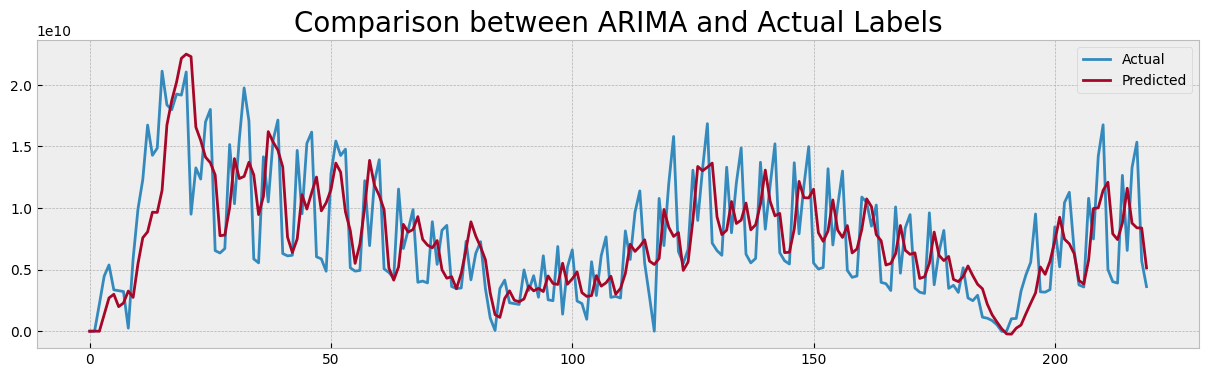

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(train['total_sales'],label='Actual')
plt.plot(arima_pred,label='Predicted')
plt.title("Comparison between ARIMA and Actual Labels", fontsize=20)
plt.legend()

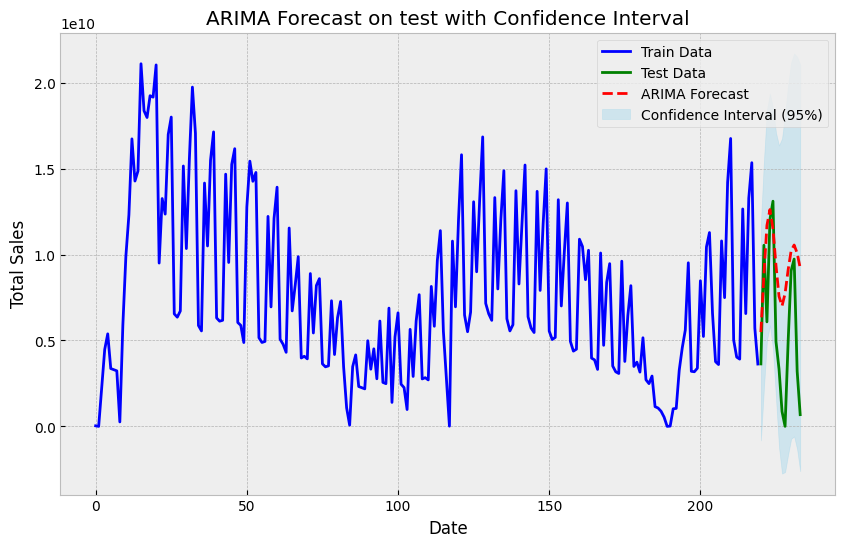

In [ ]:
forecast = arima_result.get_forecast(steps=test_size)  # Get forecast for test size
forecast_mean = forecast.predicted_mean  # Forecasted values
forecast_conf_int = forecast.conf_int()  # Confidence intervals

# Define forecasted dates
forecast_dates = test.index  # Dates for the test set
forecast_series_arima = pd.Series(forecast_mean, index=forecast_dates)

# Plot actual vs forecasted values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['total_sales'], label='Train Data', color='blue')
plt.plot(test.index, test['total_sales'], label='Test Data', color='green')
plt.plot(forecast_series_arima.index, forecast_series_arima, label='ARIMA Forecast', color='red', linestyle='dashed')

# Plot the confidence intervals
plt.fill_between(forecast_conf_int.index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color='skyblue', alpha=0.3, label='Confidence Interval (95%)')

plt.legend(loc='best')
plt.title('ARIMA Forecast on test with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()


In [ ]:
# forecasting total sales for the next 15 days
forecast_steps = 15
arima_forecast = arima_result.forecast(steps=forecast_steps)

# create a data range for the forecast
last_date = daily_sales['date'].iloc[-1]
forecast_dates = pd.date_range(last_date, periods=forecast_steps+1, inclusive='right')

arima_forecast_df = pd.DataFrame({'date': forecast_dates, 'forecast': arima_forecast})

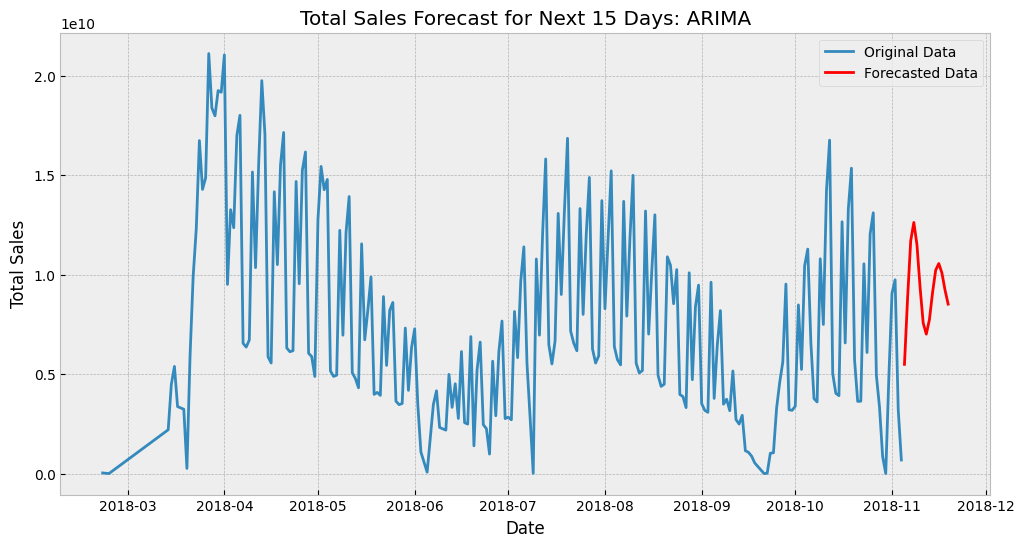

In [ ]:
# Plotting the original data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['date'], daily_sales['total_sales'], label='Original Data')
plt.plot(arima_forecast_df['date'], arima_forecast_df['forecast'], color='red', label='Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Total Sales Forecast for Next 15 Days: ARIMA')
plt.legend()
plt.show()

In [ ]:
arima_forecast_df[:5]

,date,forecast
220,2018-11-05,5.489556e+09
221,2018-11-06,8.819516e+09
222,2018-11-07,1.169907e+10
223,2018-11-08,1.262292e+10
224,2018-11-09,1.150690e+10


## 6. Forecasting with SARIMAX

In [ ]:
model=pmd.auto_arima(train['total_sales'],start_p=1,start_q=1,max_p=3,max_q=3,d=1,m=7,seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=10204.713, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=10355.181, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=10228.485, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=10253.222, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=10353.186, Time=0.02 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=10243.352, Time=0.14 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=10209.903, Time=0.22 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=10205.091, Time=0.54 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=10204.048, Time=0.58 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=10225.433, Time=0.47 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=10205.569, Time=0.99 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=10207.571, Time=0.41 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=10219.713, Time=0.32 sec
 ARIMA(2,1,1)(1,0,2)[7] intercept   : AIC=10205.610, Time=0.85 sec
 ARIMA(1,1,2)(1,0,2

In [ ]:
model1=pmd.auto_arima(train['total_sales'],start_p=1,start_q=1,max_p=3,max_q=3,d=1,m=2,seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[2] intercept   : AIC=10301.085, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[2] intercept   : AIC=10355.181, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[2] intercept   : AIC=10322.946, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[2] intercept   : AIC=10306.126, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[2]             : AIC=10353.186, Time=0.02 sec
 ARIMA(1,1,1)(0,0,1)[2] intercept   : AIC=10303.481, Time=0.17 sec
 ARIMA(1,1,1)(1,0,0)[2] intercept   : AIC=10303.763, Time=0.41 sec
 ARIMA(1,1,1)(2,0,1)[2] intercept   : AIC=10301.159, Time=0.36 sec
 ARIMA(1,1,1)(1,0,2)[2] intercept   : AIC=10301.009, Time=0.56 sec
 ARIMA(1,1,1)(0,0,2)[2] intercept   : AIC=10299.205, Time=0.28 sec
 ARIMA(0,1,1)(0,0,2)[2] intercept   : AIC=10298.408, Time=0.12 sec
 ARIMA(0,1,1)(1,0,2)[2] intercept   : AIC=10300.400, Time=0.25 sec
 ARIMA(0,1,1)(1,0,1)[2] intercept   : AIC=10300.448, Time=0.18 sec
 ARIMA(0,1,0)(0,0,2)[2] intercept   : AIC=10340.059, Time=0.09 sec
 ARIMA(1,1,0)(0,0,2

In [ ]:
sarima_model = SARIMAX(train['total_sales'], order=(0,1,2), seasonal_order=(1,0,2,7))
sarima_result = sarima_model.fit()

In [ ]:
sarima_pred = sarima_result.predict()

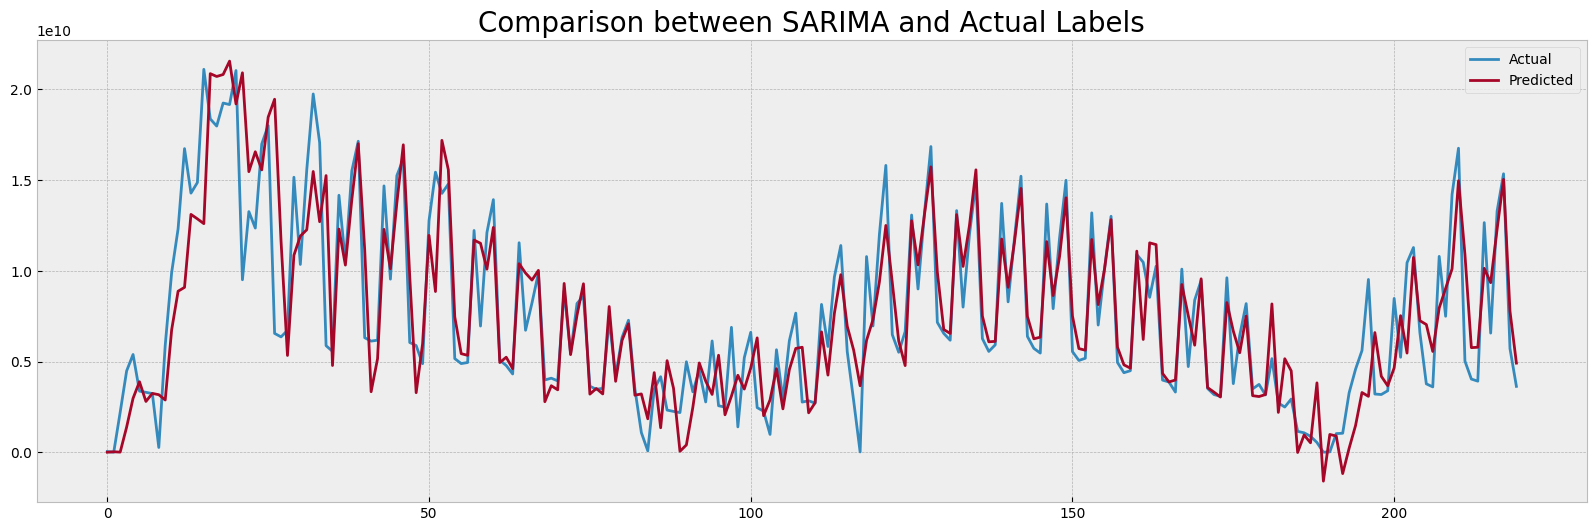

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(train['total_sales'],label='Actual')
plt.plot(sarima_pred,label='Predicted')
plt.title("Comparison between SARIMA and Actual Labels", fontsize=20)
plt.legend()

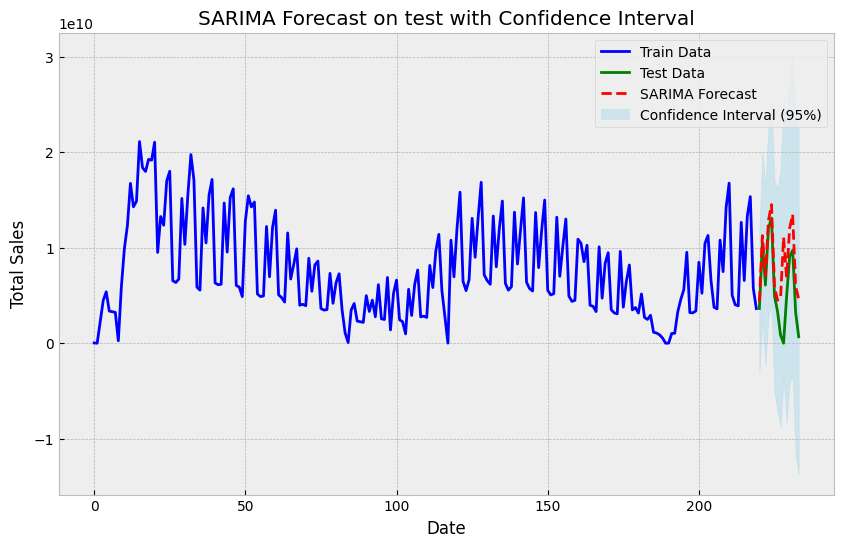

In [ ]:
forecast = sarima_result.get_forecast(steps=test_size)  # Get forecast for test size
forecast_mean = forecast.predicted_mean  # Forecasted values
forecast_conf_int = forecast.conf_int()  # Confidence intervals

# Define forecasted dates
forecast_dates = test.index  # Dates for the test set
forecast_series_sarima = pd.Series(forecast_mean, index=forecast_dates)

# Plot actual vs forecasted values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['total_sales'], label='Train Data', color='blue')
plt.plot(test.index, test['total_sales'], label='Test Data', color='green')
plt.plot(forecast_series_sarima.index, forecast_series_sarima, label='SARIMA Forecast', color='red', linestyle='dashed')

# Plot the confidence intervals
plt.fill_between(forecast_conf_int.index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color='skyblue', alpha=0.3, label='Confidence Interval (95%)')

plt.legend(loc='best')
plt.title('SARIMA Forecast on test with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()


In [ ]:
# forecasting total sales for the next 15 days
forecast_steps = 15
sarima_forecast = sarima_result.forecast(steps=forecast_steps)

# create a data range for the forecast
last_date = daily_sales['date'].iloc[-1]
forecast_dates = pd.date_range(last_date, periods=forecast_steps+1, inclusive='right')

sarima_forecast_df = pd.DataFrame({'date': forecast_dates, 'forecast': sarima_forecast})

In [ ]:
sarima_forecast_df[:5]

,date,forecast
220,2018-11-05,4.342328e+09
221,2018-11-06,1.126394e+10
222,2018-11-07,7.067509e+09
223,2018-11-08,1.285027e+10
224,2018-11-09,1.451242e+10


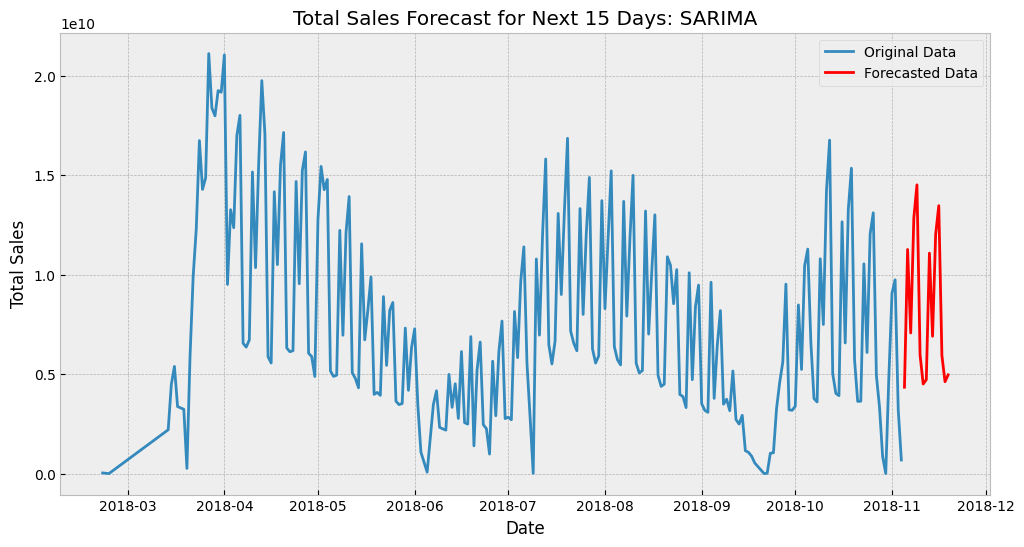

In [ ]:
# Plotting the original data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['date'], daily_sales['total_sales'], label='Original Data')
plt.plot(sarima_forecast_df['date'], sarima_forecast_df['forecast'], color='red', label='Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Total Sales Forecast for Next 15 Days: SARIMA')
plt.legend()
plt.show()

In [ ]:
arima_predictions = arima_result.fittedvalues
sarima_predictions = sarima_result.fittedvalues

arima_metrics = calculate_metrics(test['total_sales'], forecast_series_arima)
sarima_metrics = calculate_metrics(test['total_sales'], forecast_series_sarima)

metrics_df = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA','2 day SMA', '7 day SMA','14 day SMA','EWMA 2','EWMA 7'],
    'MSE': [arima_metrics['MSE'], sarima_metrics['MSE'],metrics_2['MSE'], metrics_7['MSE'],metrics_14['MSE'],metrics_ewma2['MSE'],metrics_ewma7['MSE']],
    'MAE': [arima_metrics['MAE'], sarima_metrics['MAE'],metrics_2['MAE'], metrics_7['MAE'],metrics_14['MAE'],metrics_ewma2['MAE'],metrics_ewma7['MAE']],
    'RMSE': [arima_metrics['RMSE'], sarima_metrics['RMSE'],metrics_2['RMSE'], metrics_7['RMSE'],metrics_14['RMSE'],metrics_ewma2['RMSE'],metrics_ewma7['RMSE']]
})

metrics_df

,Model,MSE,MAE,RMSE
0,ARIMA,2.258526e+19,3.967438e+09,4.752395e+09
1,SARIMA,1.388197e+19,2.652119e+09,3.725851e+09
2,2 day SMA,4.846730e+18,1.796510e+09,2.201529e+09
3,7 day SMA,1.667416e+19,3.729618e+09,4.083401e+09
4,14 day SMA,1.895032e+19,4.022291e+09,4.353196e+09
5,EWMA 2,2.204286e+18,1.378041e+09,1.484684e+09
6,EWMA 7,1.110475e+19,3.153407e+09,3.332378e+09


Evidently, 2 year Exp. Moving Average and SARIMA with seasonality 7 are performing better than the other models.